In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 20
})

In [2]:
n = 200
m = 2
y = np.random.choice([-1,1], n)
X0 = np.random.randn(n, m) - np.array([0.9, 0.9])
X1 = np.random.randn(n, m) - np.array([-0.9, -0.9])
X = X0.copy()
X[y == 1] = X1[y == 1]

In [3]:
n = 200
m = 2
X = np.random.randn(n, m)
y = np.ones(n)

mask = (X[:,0]**2 + X[:,1]**2 > 1)
y[mask] = -1

/home/chris/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


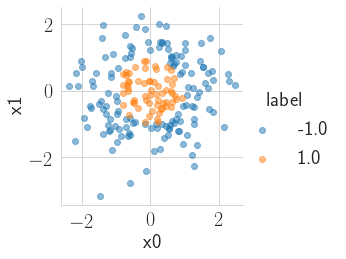

In [4]:
df = pd.DataFrame(X)
df.columns = ['x0', 'x1']
df['label']= y

sns.set_style("whitegrid")
sns.FacetGrid(df, hue="label", size=4) \
   .map(plt.scatter, "x0", "x1", alpha = 0.5) \
   .add_legend()
plt.show()

In [5]:

def kernel(x,z):
    if len(x.shape)==1:
        x = x[None, :]
    if len(z.shape)==1:
        z = z[None, :]
    return x.dot(z.T)

def kernel(x,z):
    if len(x.shape)==1:
        x = x[None, :]
    if len(z.shape)==1:
        z = z[None, :]
    return (x.dot(z.T) + 1)**2

def kernel(x,z):
    if len(x.shape)==1:
        x = x[None, :]
    if len(z.shape)==1:
        z = z[None, :]
    sigma = 1
    dist = np.linalg.norm(x[:, None, :] - z[None, :, :], axis=-1)
    return np.exp(-dist**2 /(2*sigma**2))
    

def find_b(alpha_s, C, X_s, y_s):
    k_s = kernel(X_s, X_s)
    ayk_term = alpha_s[None,:] * y_s[None,:] * k_s
    diff = y_s - np.sum(ayk_term, axis=1)
    
    if diff.size > 0: 
        b = np.mean(diff)
    else:
        b = 0
    return b
        
def f(alpha, C, X, y, z, tol=1e-3):
    support_mask = (alpha > tol)*(alpha < (C-tol))
    #print(sum(support_mask))
    
    if sum(support_mask) == 0:
        return 0
    
    X_s = X[support_mask, :]
    K_s = kernel(X_s, z) # n x 1 vector
    alpha_s = alpha[support_mask]
    y_s = y[support_mask]
    
    ayk_term = alpha_s * y_s * K_s[:,0]
    b = find_b(alpha_s, C, X_s, y_s)   
    
    return sum(ayk_term) + b

n, m = X.shape
tol = 1e-3
num_iterations = int(1e3)
alpha = np.zeros(n)
C = 2

for _ in tqdm(range(num_iterations)):
    i, j = np.random.choice(np.arange(n), 2, replace = False)

    x1 = X[i, :]
    x2 = X[j, :]
    y1 = y[i]
    y2 = y[j]
    a1_old = alpha[i]
    a2_old = alpha[j]
    
    if y1 == y2:
        L = max(0, a2_old + a1_old - C)
        H = min(C, a2_old + a1_old)
    else:
        L = max(0, a2_old - a1_old)
        H = min(C, C + a2_old - a1_old)
    
    # second derivative of objective along diagonal line for constraint
    nu = 2 * kernel(x1, x2)- kernel(x1, x1) - kernel(x2, x2)
    nu = nu[0,0]
    
    E1 = f(alpha, C, X, y, x1) - y1
    E2 = f(alpha, C, X, y, x2) - y2
    
    a2_new = a2_old - y2*(E1-E2)/nu
    
    if a2_new >= H:
        a2_new = H
    if a2_new <= L:
        a2_new = L
    
    s = y1*y2
    
    a1_new = a1_old + s*(a2_old - a2_new)
    
    alpha[i] = a1_new
    alpha[j] = a2_new

100%|██████████| 1000/1000 [00:01<00:00, 775.71it/s]


/home/chris/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


(71289, 2)


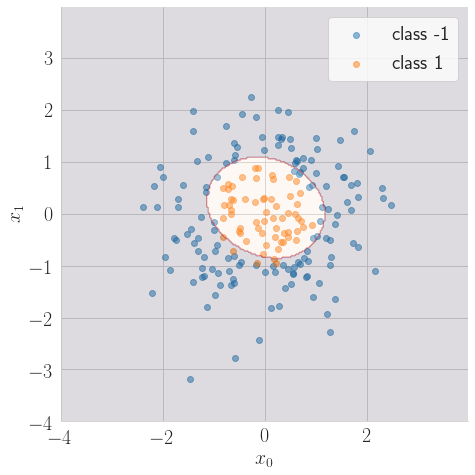

In [6]:

def plot_label_heatmap(ax):
    delta = 0.03
    xc = np.arange(-4.0, 4.0, delta)
    yc = np.arange(-4.0, 4.0, delta)
    X_contour, Y_contour = np.meshgrid(xc, yc)

    XY_contour = np.stack([X_contour.flatten(), 
              Y_contour.flatten()], axis= 1)
    print(XY_contour.shape)
    Z0 = np.zeros(XY_contour.shape[0])
    for i in range(XY_contour.shape[0]):
        Z0[i] = f(alpha, C, X, y, XY_contour[i, :])
        
    Z0 = 1*(Z0 > 0.0)
    Z0 = Z0.reshape(X_contour.shape)
    CS = ax.contourf(X_contour, Y_contour, Z0, alpha = 0.15)
    return ax
    
res = sns.FacetGrid(data=df, hue="label", size=7) \
   .map(plt.scatter, "x0", "x1", alpha = 0.5) \
   #.add_legend()

ax = res.ax

ax = plot_label_heatmap(ax)

ax.set_xlabel(r'$x_0$', fontsize = 20)
ax.set_ylabel(r'$x_1$', fontsize = 20)


# replace labels
new_labels = [r'class -1', r'class 1']
ax.legend(
    labels = new_labels
)
plt.show()


fig = res.fig
fig.savefig("../images/SVM.svg", format="svg", bbox_inches='tight') 